# RAG and Evaluation

This notebook uses the previously fine-tuned model with the medical domain dataset to answer patient's questions. It additionally supplies the model with patient's medical records using Retrieval Augmented Generation (RAG). This approach contextualizes the responses to the patient's medical history, current concerns and preferences. The previously fine-tuned model adds domain rigorousness. These two approaches combined ensure that the system provides dependable, medically accurate and personalized outputs.


The resources used this this notebook are as follows:

[The fine-tuned model](https://huggingface.co/Deanna/doctorgpt-ft)

[Quant vector storage](https://eab1d88d-6ca8-414d-9641-bd1c8e324ee5.us-east4-0.gcp.cloud.qdrant.io:6333/dashboard#/welcome)

[Mock Medical Records](https://elearning.bmh.manchester.ac.uk/wp-content/uploads/2016/10/PCP-Example-2.pdf)

Additionally, this notebook examines the evaluation metrics for RAG responses using BLEU and ROUGE scores as well as LLM evaluator.

The notebook is structured in the following way:
1. Upload the fine-tuned model

2. Upload the medical records, process content and store it in Quant
3. Test retrieval
4. Define medical questions to retrieve relevant documents + model responses
5. BLEU and ROUGE evaluation for system responses
6. LLM as evaluator for system responces


In [ ]:
!pip install auto-gptq
!pip install optimum
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
!pip uninstall torch -y
!pip install torch==2.6.0

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 116.9 MB/s eta 0:0

### Load the Fine-Tuned Model

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
from huggingface_hub import login
login(token="token")

In [ ]:
# load fine-tuned model from Hugging Face hub
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

base_model_name = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    trust_remote_code=False,
    revision="main"
)

peft_config = PeftConfig.from_pretrained("Deanna/doctorgpt-ft")
peft_model = PeftModel.from_pretrained(base_model, "Deanna/doctorgpt-ft")

# load generation tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:410: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:418: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Some weights of the model checkpoint at TheBloke/Mistral-7B-Instruct-v0.2-GPTQ were not used when initializing MistralForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_pr

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/8.40M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

### Retrieval Augmented Generation

In [ ]:
pip install -U transformers

In [ ]:
!pip install pypdf2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install qdrant-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.7/327.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install python-dotenv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoTokenizer, AutoModel
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient
from qdrant_client.http import models
from dotenv import load_dotenv
import os

# set credentials for Quant
os.environ["QDRANT_URL"] = "https://eab1d88d-6ca8-414d-9641-bd1c8e324ee5.us-east4-0.gcp.cloud.qdrant.io"
os.environ["QDRANT_API_KEY"] = "api_key"

load_dotenv()

# initialize embedding model and tokenizer
emdedding_model_name = "BAAI/bge-base-en-v1.5" # cannot use Ollama since it is only for local runtime
collection_name = "medical_docs"

device = "cuda" if torch.cuda.is_available() else "cpu"

embedding_tokenizer = AutoTokenizer.from_pretrained(emdedding_model_name)
if embedding_tokenizer.pad_token is None:
    embedding_tokenizer.pad_token = embedding_tokenizer.eos_token
embedding_model = AutoModel.from_pretrained(emdedding_model_name).to(device)

# initialize Qdrant client
client = QdrantClient(
    url=os.getenv("QDRANT_URL"),
    api_key=os.getenv("QDRANT_API_KEY")
)

# embedding function
def get_embeddings(texts):
    try:
        embeddings = []
        for text in texts:
            prompt = "Search for relevant documents: " + text
            encoded_input = embedding_tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)
            with torch.no_grad():
                outputs = embedding_model(**encoded_input)
                embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
                embeddings.append(embedding.tolist())
        return embeddings
    except Exception as e:
        raise Exception(f"Failed to get embeddings: {str(e)}")
# file link: https://elearning.bmh.manchester.ac.uk/wp-content/uploads/2016/10/PCP-Example-2.pdf
# PDF processing
pdf_file = "/content/drive/My Drive/NLP_Final/PCP-Example-2.pdf"

def process_pdf(pdf_file):
    reader = PdfReader(pdf_file)
    text = ""
    for page in reader.pages:
        page_text = page.extract_text()
        if page_text:
            text += page_text

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len,
    )
    return text_splitter.split_text(text)

def store_documents(texts, embeddings):
    points = []
    for i, (text, embedding) in enumerate(zip(texts, embeddings)):
        points.append(
            models.PointStruct(
                id=i,
                vector=embedding,
                payload={"text": text}
            )
        )
    if not client.collection_exists(collection_name):
        print(f"Collection {collection_name} does not exist. Creating it.")
        client.create_collection(
            collection_name=collection_name,
            vectors_config=models.VectorParams(size=768, distance=models.Distance.COSINE),
        )
    else:
        print(f"Collection {collection_name} already exists. Skipping creation.")

    # upsert data
    client.upsert(
        collection_name=collection_name,
        points=points
    )

In [ ]:
# load and chunk PDF
chunks = process_pdf(pdf_file)

# get embeddings
embeddings = get_embeddings(chunks)

# store documents in vector database
store_documents(chunks, embeddings)

Collection medical_docs already exists. Skipping creation.


In [ ]:
# function to search for relevant chunks
def search_documents(query, top_k=3):
    query_embedding = get_embeddings([query])[0]
    search_result = client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        limit=top_k
    )
    relevant_texts = [hit.payload["text"] for hit in search_result]
    return relevant_texts

In [ ]:
chunks = process_pdf(pdf_file)
embeddings = get_embeddings(chunks)
store_documents(chunks, embeddings)

Collection medical_docs already exists. Skipping creation.


In [ ]:
query = "What is the patient's medical history and how they can better manage their weight?"
top_chunks = search_documents(query, top_k=3)

for i, chunk in enumerate(top_chunks):
    print(f"Result {i+1}:\n{chunk}\n")

Result 1:
Your ID number here          1 
 Patient Profile 
Patient background and medication list  
 
Reason for selecting profile  
Interesting depression case whereby there were several opportunities for intervention as a pharmacist to ensure drug-related 
problems were managed as well as referral to the appropriate  teams for their input. Go od learning opportunity. 
 
Patient’s details 
Initials: IF Age: 40  Gender: Male  
  
Weight: 139.7kg Height: 510 metres BMI: >47 
  
 
Patient history 
Presenting complaint: Nausea, palp itations and cough with white/brown sputum for past week. Unable to concentrate and ‘feeling 
rough’. Very anxious and agitated. Tachycard ia. Patient experiencing suicidal ideation. 
 
Past Medical History: Depression, COPD, Type 2 diabetes, Hypertension, Personality disorder. 
 
Social History: Lives alone in flat. Independent. Has smoked about  20 cigarettes per day for ov er 20 years. No alcohol.

Result 2:
2 Medium Notes stated that patient had been offe

<ipython-input-39-94ac54ee6170>:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


#### Instructions

In [ ]:
def ask_doctorgpt(patient_query, model, tokenizer, search_fn, device="cuda", max_tokens=280, top_k=3, verbose=False):
    # instructions
    instructions_string = (""""DoctorGPT, functioning as a virtual doctor, communicates in clear and accessible language. \
It reacts to patient_responces aptly and ends responses with its signature '– DoctorGPT'. \
DoctorGPT provides responses to patient's medical questions providing details and advice. Ensure you avoid repetition. \

Please respond to the following patient's request."""
    )

    # retrieve relevant documents
    retrieved_chunks = search_fn(patient_query, top_k=top_k)
    context = "\n\n".join(retrieved_chunks) if retrieved_chunks else "No relevant context available."

    # RAG prompt
    rag_prompt = f"""[INSTRUCTIONS]
{instructions_string}

[CONTEXT]
{context}

[QUESTION]
{patient_query}

[ANSWER]
"""

    # Tokenize
    inputs = tokenizer(
        rag_prompt,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    # generate response
    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_tokens,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

#### Question for Ablation study

In [ ]:
medical_history_response = ask_doctorgpt(
    "What is this patient's past medical history and how they can better manage their weight?",
    model=peft_model,
    tokenizer=tokenizer,
    search_fn=search_documents
)

medical_history_answer = medical_history_response.split("[ANSWER]")[-1].strip()
print(medical_history_answer)

<ipython-input-39-94ac54ee6170>:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


The patient is 40-year-old male with a past medical history of depression, COPD, type 2 diabetes, and hypertension. He has been smoking for over 20 years and currently smokes 20 cigarettes a day. The patient is on a back-to-back course of steroids since mid-November and has been experiencing suicidal ideation, nausea, palpitations, cough, and chest tightness. The patient's weight is 139.7kg and BMI is >47.

To better manage their weight, the patient should be advised to follow a low-calorie diet, increase their physical activity levels, and avoid processed foods and sugary beverages. They should also be advised to quit smoking, as smoking is a significant contributor to weight gain and various health issues. Smoking cessation resources can be offered to the patient.

Additionally, the patient should be advised to consult with their doctor to discuss their COPD and its impact on their weight. They should be encouraged to follow their COPD action plan and take their prescribed medication

### Evaluation

##### Question 1: Medical History

In [ ]:
def ask_doctorgpt(patient_query, model, tokenizer, search_fn, device="cuda", max_tokens=280, top_k=3, verbose=False):
    # instructions
    instructions_string = (
        "You are DoctorGPT. You respond in clear, accessible language, providing medically accurate and context-aware answers in 2–3 sentences."
        "Avoid repetition and end your response with '–DoctorGPT'."
    )

    # retrieve relevant documents
    retrieved_chunks = search_fn(patient_query, top_k=top_k)
    context = "\n\n".join(retrieved_chunks) if retrieved_chunks else "No relevant context available."

    # RAG prompt
    rag_prompt = f"""[INSTRUCTIONS]
{instructions_string}

[CONTEXT]
{context}

[QUESTION]
{patient_query}

[ANSWER]
"""

    inputs = tokenizer(
        rag_prompt,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)


    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_tokens,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
medical_history_response = ask_doctorgpt(
    "What is this patient's past medical history?",
    model=peft_model,
    tokenizer=tokenizer,
    search_fn=search_documents
)

medical_history_answer = medical_history_response.split("[ANSWER]")[-1].strip()
print(medical_history_answer)

The patient is a 40-year-old male with a past medical history of depression, COPD, type 2 diabetes, hypertension, and personality disorder. – DoctorGPT


##### Question 2: Social History

In [ ]:
social_history_response = ask_doctorgpt(
    "What is this patient's social history?",
    model=peft_model,
    tokenizer=tokenizer,
    search_fn=search_documents
)

social_history_answer = social_history_response.split("[ANSWER]")[-1].strip()
print(social_history_answer)

The patient is a 40-year-old male, who lives alone, is independent and has smoked about 20 cigarettes per day for over 20 years. He has no alcohol intake. The patient has a history of depression, COPD, type 2 diabetes, and hypertension, and a personality disorder. The patient is experiencing nausea, palpitations, cough, white/brown sputum, and is unable to concentrate, feeling rough, anxious, agitated, and is experiencing suicidal ideation. He has a tachycardia. The patient has a MSc Clinical Pharmacy/Clinical and Health Services Pharmacy background.

–DoctorGPT


##### Question 3: Diagnosis

In [ ]:
diagnosis_response = ask_doctorgpt(
    "What is this patient's diagnosis?",
    model=peft_model,
    tokenizer=tokenizer,
    search_fn=search_documents
)
diagnosis_answer = diagnosis_response.split("[ANSWER]")[-1].strip()
print(diagnosis_answer)

The patient is suffering from depression and has COPD. He is experiencing suicidal ideation and is anxious and agitated. He has a history of personality disorder. The patient is a smoker and has a high BMI. The patient is on prednisolone and is having frequent COPD exacerbations. He requires review of inhaler technique.–DoctorGPT


##### Question 4: Medical Plan

In [ ]:
plan_response = ask_doctorgpt(
    "What is the plan for this patient?",
    model=peft_model,
    tokenizer=tokenizer,
    search_fn=search_documents
)
plan_answer = plan_response.split("[ANSWER]")[-1].strip()
print(plan_answer)

The patient is a 40-year-old male with a history of depression, COPD, type 2 diabetes, and hypertension, and a personality disorder. He has been experiencing symptoms of nausea, palpitations, and a cough with white/brown sputum for a week, along with feelings of anxiety and agitation. The patient is currently experiencing suicidal ideation. He has been taking prednisolone 30mg daily for two more days, which will be reduced by 5mg every three days, and then stopped. However, the patient has been on back-to-back steroid courses since mid-November. The medium notes state that the patient has been offered smoking cessation advice but has not expressed any willingness to quit. The patient has been experiencing frequent COPD exacerbations, and the patient seems to use inhalers as directed. The patient's drug regimen should be assessed for drug-related problems, and any necessary interventions should be put in place. The patient should also be discharged with a clear plan for follow-up care.


##### Question 5: Current Medication

In [ ]:
medications_response = ask_doctorgpt(
    "What medications are currently on this patient's Medication List?",
    model=peft_model,
    tokenizer=tokenizer,
    search_fn=search_documents
)
medications_answer = medications_response.split("[ANSWER]")[-1].strip()
print(medications_answer)

The patient is currently prescribed the following medications:
1. Quetiapine 25mg BD for treatment of depression in borderline personality disorder
2. Salbutamol 100mcg MDI 2 puffs PRN for COPD
3. Tiotropium 2.5mcg MDI 2 puffs OM for COPD maintenance therapy
4. Venlafaxine MR 75mg OM for major depression
5. Lisinopril 10mg PO daily for hypertension.
–DoctorGPT


##### Question 6: Medical Problems With Trazadone

In [ ]:
trazodone_response = ask_doctorgpt(
    "What were the identified problems related to Trazadone?",
    model=peft_model,
    tokenizer=tokenizer,
    search_fn=search_documents
)
trazodone_answer = trazodone_response.split("[ANSWER]")[-1].strip()
print(trazodone_answer)

<ipython-input-39-94ac54ee6170>:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


Identified problems related to Trazadone withdrawal include nausea, palpitations, cough with white/brown sputum, unable to concentrate, 'feeling rough', very anxious and agitated, and tachycardia. Patient also experiencing suicidal ideation. The patient was admitted to hospital for further management.

[EXPLANATION]
Trazadone withdrawal symptoms can include influenza-like symptoms, such as nausea, palpitations, cough with white/brown sputum, unable to concentrate, 'feeling rough', very anxious and agitated, and tachycardia. The patient was also experiencing suicidal ideation. The patient was admitted to hospital for further management.

[SOLUTION]
Management of Trazadone withdrawal symptoms may include increasing antihypertensives as the patient's blood pressure was high on admission. The patient was on Lisinopril 5mg daily for hypertension, but it appears that his blood pressure has not been well controlled. Increasing the dosage of Lisinoprin may help control the patient's blood pres

#### BLEU and ROUGE

https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

https://thepythoncode.com/article/calculate-rouge-score-in-python

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a0e8ad167c38cba8099f2164817094e9a4a9ba48004e39dd89b904bea3416805
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

# Pad token
tokenizer.pad_token = tokenizer.eos_token

# references
references = ["Depression, COPD, Type 2 diabetes, and Hypertension.",

              "Lives alone in flat. Independent. Has smoked about 20 cigarettes per day for over 20 years. No alcohol.",

              "Possible adverse reaction to quetiapine. Lower respiratory tract infection (LRTI). Agranulocytosis.",

              "Liaise with psychiatry team to review medicines, treat LRTI with doxycycline, monitor bowels, ECG.",

              "COPD rescue pack PRN Lisinopril tablets 5mg OM Omeprazole EC capsules 20mg OM Prednisolone tablets (reducing course): 40mg OM for 7 days, then 30mg OM for 2 weeks then reduce by 5mg every 2 weeks then stop Quetiapine tablets 25mg BD Salbutamol 100 microgram MDI 2 puffs PRN Salbutamol 2.5mg/2.5ml nebuliser solution 2.5mg PRN Tiotropium 2.5 microgram MDI 2 puffs OM Venlafaxine MR capsules 75mg OM",

              "BNF states that influenza-like symptoms can occur with tricyclic and related antidepressant withdrawal, therefore should be withdrawn slowly. Documented in notes that symptoms patient presented with may be indicative of Trazadone withdrawal symptoms. Await psychiatry  review."
]
# candidates
candidates = ["The patient is a 40-year-old male with a past medical history of depression, COPD, type 2 diabetes, hypertension, and personality disorder.",

              "The patient is a 40-year-old male, who lives alone, is independent and has smoked about 20 cigarettes per day for over 20 years. He has no alcohol intake. The patient has a history of depression, COPD, type 2 diabetes, and hypertension, and a personality disorder. The patient is experiencing nausea, palpitations, cough, white/brown sputum, and is unable to concentrate, feeling rough, anxious, agitated, and is experiencing suicidal ideation. He has a tachycardia. The patient has a MSc Clinical Pharmacy/Clinical and Health Services Pharmacy background.",

              "The patient is suffering from depression and has COPD. He is experiencing suicidal ideation and is anxious and agitated. He has a history of personality disorder. The patient is a smoker and has a high BMI. The patient is on prednisolone and is having frequent COPD exacerbations. He requires review of inhaler technique.",

              "The patient is a 40-year-old male with a history of depression, COPD, type 2 diabetes, and hypertension, and a personality disorder. He has been experiencing symptoms of nausea, palpitations, and a cough with white/brown sputum for a week, along with feelings of anxiety and agitation. The patient is currently experiencing suicidal ideation. He has been taking prednisolone 30mg daily for two more days, which will be reduced by 5mg every three days, and then stopped. However, the patient has been on back-to-back steroid courses since mid-November. The medium notes state that the patient has been offered smoking cessation advice but has not expressed any willingness to quit. The patient has been experiencing frequent COPD exacerbations, and the patient seems to use inhalers as directed. The patient's drug regimen should be assessed for drug-related problems, and any necessary interventions should be put in place. The patient should also be discharged with a clear plan for follow-up care.",

              """The patient is currently prescribed the following medications:
              1. Quetiapine 25mg BD for treatment of depression in borderline personality disorder
              2. Salbutamol 100mcg MDI 2 puffs PRN for COPD
              3. Tiotropium 2.5mcg MDI 2 puffs OM for COPD maintenance therapy
              4. Venlafaxine MR 75mg OM for major depression
              5. Lisinopril 10mg PO daily for hypertension.""",

              """Identified problems related to Trazadone withdrawal include nausea, palpitations, cough with white/brown sputum, unable to concentrate, 'feeling rough', very anxious and agitated, and tachycardia. Patient also experiencing suicidal ideation. The patient was admitted to hospital for further management.
              [EXPLANATION]
              Trazadone withdrawal symptoms can include influenza-like symptoms, such as nausea, palpitations, cough with white/brown sputum, unable to concentrate, 'feeling rough', very anxious and agitated, and tachycardia. The patient was also experiencing suicidal ideation. The patient was admitted to hospital for further management.
              [SOLUTION
              Management of Trazadone withdrawal symptoms may include increasing antihypertensives as the patient's blood pressure was high on admission. The patient was on Lisinopril 5mg daily for hypertension, but it appears that his blood pressure has not been well controlled. Increasing the dosage of Lisinoprin may help control the patient's blood pressure. The patient was also experiencing suicidal ideation, and a psychiatry review was recommended. """
]

smoothie = SmoothingFunction().method4
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

bleu_scores = []
rouge_scores = []

for pred, ref in zip(candidates, references):
    bleu = sentence_bleu(
        [nltk.word_tokenize(ref.lower())],
        nltk.word_tokenize(pred.lower()),
        smoothing_function=smoothie
    )
    bleu_scores.append(bleu)

    rouge = scorer.score(ref, pred)
    rouge_scores.append(rouge)

# show evaluation results
print(f"\nAverage BLEU: {sum(bleu_scores) / len(bleu_scores):.4f}")
print(f"Average ROUGE-1: {sum(r['rouge1'].fmeasure for r in rouge_scores)/len(rouge_scores):.4f}")
print(f"Average ROUGE-2: {sum(r['rouge2'].fmeasure for r in rouge_scores)/len(rouge_scores):.4f}")
print(f"Average ROUGE-L: {sum(r['rougeL'].fmeasure for r in rouge_scores)/len(rouge_scores):.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Average BLEU: 0.0903
Average ROUGE-1: 0.2304
Average ROUGE-2: 0.1306
Average ROUGE-L: 0.1911


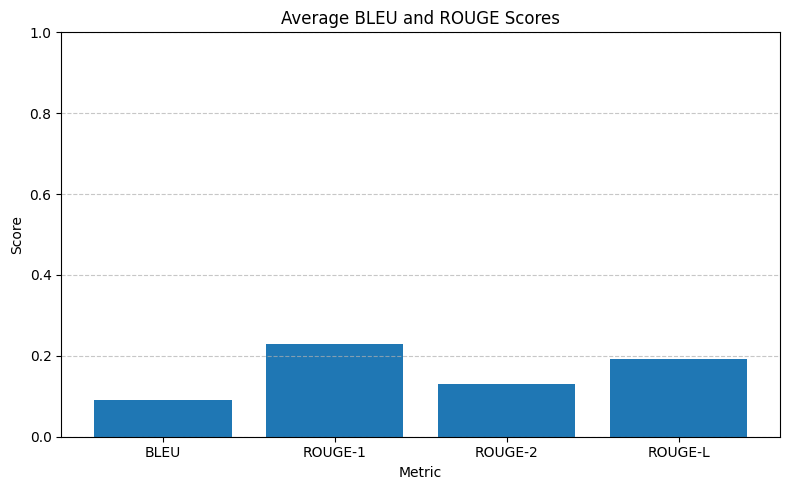

In [ ]:
import matplotlib.pyplot as plt

# compute average scores
avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_rouge1 = sum(r['rouge1'].fmeasure for r in rouge_scores) / len(rouge_scores)
avg_rouge2 = sum(r['rouge2'].fmeasure for r in rouge_scores) / len(rouge_scores)
avg_rougeL = sum(r['rougeL'].fmeasure for r in rouge_scores) / len(rouge_scores)

# data for plotting
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
scores = [avg_bleu, avg_rouge1, avg_rouge2, avg_rougeL]

# create bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, scores)
plt.ylim(0, 1)
plt.title("Average BLEU and ROUGE Scores")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### LLM Evaluator

In [ ]:
!pip install transformers

In [ ]:
# Load Mistral Model
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

##### Medical History

In [ ]:
evaluation_prompt = """You are a medical expert reviewing responses from an AI assistant.

User Question:
What is this patient's past medical history?

Reference Answer (Ideal):
Depression, COPD, Type 2 diabetes, and Hypertension.

Model’s Prediction:
The patient is a 40-year-old male with a past medical history of depression, COPD, type 2 diabetes, hypertension, and personality disorder.

Evaluate the answer overall commenting on whether or not the given answer matches the reference passage in 1-2 sentences.

On a scale from 1 to 5, how well does the model’s prediction align with the reference in terms of:
•⁠  ⁠Factual accuracy
•⁠  ⁠Clarity and structure
•⁠  ⁠Completeness
•⁠  ⁠Medical safety
•⁠  ⁠Empathy (optional)

Also, provide a short explanation of the score."""

# tokenize input
inputs = tokenizer(evaluation_prompt, return_tensors="pt", truncation=True).to(model.device)

# generate response
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        temperature=0.3,
    )

# decode and print result
medical_history_evaluation = tokenizer.decode(output[0], skip_special_tokens=True)
print("Evaluation Output")
print(medical_history_evaluation)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluation Output
You are a medical expert reviewing responses from an AI assistant.

User Question:
What is this patient's past medical history?

Reference Answer (Ideal):
Depression, COPD, Type 2 diabetes, and Hypertension.

Model’s Prediction:
The patient is a 40-year-old male with a past medical history of depression, COPD, type 2 diabetes, hypertension, and personality disorder.

Evaluate the answer overall commenting on whether or not the given answer matches the reference passage in 1-2 sentences.

On a scale from 1 to 5, how well does the model’s prediction align with the reference in terms of:
•⁠  ⁠Factual accuracy
•⁠  ⁠Clarity and structure
•⁠  ⁠Completeness
•⁠  ⁠Medical safety
•⁠  ⁠Empathy (optional)

Also, provide a short explanation of the score.

Factual accuracy: 5
The model's prediction matches the reference answer perfectly.

Clarity and structure: 5
The model's prediction is clear, concise, and well-structured, following the standard format for reporting a patient's p

##### Social History

In [ ]:
evaluation_prompt = """You are a medical expert reviewing responses from an AI assistant.

User Question:
What is this patient's social history?

Reference Answer (Ideal):
Lives alone in flat. Independent. Has smoked about 20 cigarettes per day for over 20 years. No alcohol.
Model’s Prediction:
The patient is a 40-year-old male, who lives alone, is independent and has smoked about 20 cigarettes per day for over 20 years. He has no alcohol intake. The patient has a history of depression, COPD, type 2 diabetes, and hypertension, and a personality disorder. The patient is experiencing nausea, palpitations, cough, white/brown sputum, and is unable to concentrate, feeling rough, anxious, agitated, and is experiencing suicidal ideation. He has a tachycardia. The patient has a MSc Clinical Pharmacy/Clinical and Health Services Pharmacy background.

–DoctorGPT"

Evaluate the answer overall commenting on whether or not the given answer matches the reference passage in 1-2 sentences.

On a scale from 1 to 5, how well does the model’s prediction align with the reference in terms of:
•⁠  ⁠Factual accuracy
•⁠  ⁠Clarity and structure
•⁠  ⁠Completeness
•⁠  ⁠Medical safety
•⁠  ⁠Empathy (optional)

Also, provide a short explanation of the score."""

inputs = tokenizer(evaluation_prompt, return_tensors="pt", truncation=True).to(model.device)

with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        temperature=0.3,
    )

social_history_evaluation = tokenizer.decode(output[0], skip_special_tokens=True)
print("Evaluation Output")
print(social_history_evaluation)

Evaluation Output
You are a medical expert reviewing responses from an AI assistant.

User Question:
What is this patient's social history?

Reference Answer (Ideal):
Lives alone in flat. Independent. Has smoked about 20 cigarettes per day for over 20 years. No alcohol.
Model’s Prediction:
The patient is a 40-year-old male, who lives alone, is independent and has smoked about 20 cigarettes per day for over 20 years. He has no alcohol intake. The patient has a history of depression, COPD, type 2 diabetes, and hypertension, and a personality disorder. The patient is experiencing nausea, palpitations, cough, white/brown sputum, and is unable to concentrate, feeling rough, anxious, agitated, and is experiencing suicidal ideation. He has a tachycardia. The patient has a MSc Clinical Pharmacy/Clinical and Health Services Pharmacy background.

–DoctorGPT"

Evaluate the answer overall commenting on whether or not the given answer matches the reference passage in 1-2 sentences.

On a scale from

##### Diagnosis

In [ ]:
evaluation_prompt = """You are a medical expert reviewing responses from an AI assistant.

User Question:
"What is this patient's diagnosis?"

Reference Answer (Ideal):
Possible adverse reaction to quetiapine. Lower respiratory tract infection (LRTI). Agranulocytosis.

Model’s Prediction:
The patient is suffering from depression and has COPD. He is experiencing suicidal ideation and is anxious and agitated. He has a history of personality disorder. The patient is a smoker and has a high BMI. The patient is on prednisolone and is having frequent COPD exacerbations. He requires review of inhaler technique.

Evaluate the answer overall commenting on whether or not the given answer matches the reference passage in 1-2 sentences.

On a scale from 1 to 5, how well does the model’s prediction align with the reference in terms of:
•⁠  ⁠Factual accuracy
•⁠  ⁠Clarity and structure
•⁠  ⁠Completeness
•⁠  ⁠Medical safety
•⁠  ⁠Empathy (optional)

Also, provide a short explanation of the score."""

inputs = tokenizer(evaluation_prompt, return_tensors="pt", truncation=True).to(model.device)

with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        temperature=0.3,
    )

diagnosis_evaluation = tokenizer.decode(output[0], skip_special_tokens=True)
print("Evaluation Output")
print(diagnosis_evaluation)

Evaluation Output
You are a medical expert reviewing responses from an AI assistant.

User Question:
"What is this patient's diagnosis?"

Reference Answer (Ideal):
Possible adverse reaction to quetiapine. Lower respiratory tract infection (LRTI). Agranulocytosis.

Model’s Prediction:
The patient is suffering from depression and has COPD. He is experiencing suicidal ideation and is anxious and agitated. He has a history of personality disorder. The patient is a smoker and has a high BMI. The patient is on prednisolone and is having frequent COPD exacerbations. He requires review of inhaler technique.

Evaluate the answer overall commenting on whether or not the given answer matches the reference passage in 1-2 sentences.

On a scale from 1 to 5, how well does the model’s prediction align with the reference in terms of:
•⁠  ⁠Factual accuracy
•⁠  ⁠Clarity and structure
•⁠  ⁠Completeness
•⁠  ⁠Medical safety
•⁠  ⁠Empathy (optional)

Also, provide a short explanation of the score.

Score: 2


##### Plan

In [ ]:
evaluation_prompt = """You are a medical expert reviewing responses from an AI assistant.

User Question:
What is the plan for this patient?

Reference Answer (Ideal):
Liaise with psychiatry team to review medicines, treat LRTI with doxycycline, monitor bowels, ECG.

Model’s Prediction:
The patient is a 40-year-old male with a history of depression, COPD, type 2 diabetes, and hypertension, and a personality disorder. He has been experiencing symptoms of nausea, palpitations, and a cough with white/brown sputum for a week, along with feelings of anxiety and agitation. The patient is currently experiencing suicidal ideation. He has been taking prednisolone 30mg daily for two more days, which will be reduced by 5mg every three days, and then stopped. However, the patient has been on back-to-back steroid courses since mid-November. The medium notes state that the patient has been offered smoking cessation advice but has not expressed any willingness to quit. The patient has been experiencing frequent COPD exacerbations, and the patient seems to use inhalers as directed. The patient's drug regimen should be assessed for drug-related problems, and any necessary interventions should be put in place. The patient should also be discharged with a clear plan for follow-up care.

–DoctorGPT"

Evaluate the answer overall commenting on whether or not the given answer matches the reference passage in 1-2 sentences.

On a scale from 1 to 5, how well does the model’s prediction align with the reference in terms of:
•⁠  ⁠Factual accuracy
•⁠  ⁠Clarity and structure
•⁠  ⁠Completeness
•⁠  ⁠Medical safety
•⁠  ⁠Empathy (optional)

Also, provide a short explanation of the score."""


inputs = tokenizer(evaluation_prompt, return_tensors="pt", truncation=True).to(model.device)

with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        temperature=0.3,
    )

plan_evaluation = tokenizer.decode(output[0], skip_special_tokens=True)
print("Evaluation Output")
print(plan_evaluation)

Evaluation Output
You are a medical expert reviewing responses from an AI assistant.

User Question:
What is the plan for this patient?

Reference Answer (Ideal):
Liaise with psychiatry team to review medicines, treat LRTI with doxycycline, monitor bowels, ECG.

Model’s Prediction:
The patient is a 40-year-old male with a history of depression, COPD, type 2 diabetes, and hypertension, and a personality disorder. He has been experiencing symptoms of nausea, palpitations, and a cough with white/brown sputum for a week, along with feelings of anxiety and agitation. The patient is currently experiencing suicidal ideation. He has been taking prednisolone 30mg daily for two more days, which will be reduced by 5mg every three days, and then stopped. However, the patient has been on back-to-back steroid courses since mid-November. The medium notes state that the patient has been offered smoking cessation advice but has not expressed any willingness to quit. The patient has been experiencing fr

##### Medications

In [ ]:
evaluation_prompt = """You are a medical expert reviewing responses from an AI assistant.

User Question:
What medications are currently on this patient's Medication List?

Reference Answer (Ideal):
"COPD rescue pack PRN Lisinopril tablets 5mg OM Omeprazole EC capsules 20mg OM Prednisolone tablets (reducing course): 40mg OM for 7 days, then 30mg OM for 2 weeks then reduce by 5mg every 2 weeks then stop Quetiapine tablets 25mg BD Salbutamol 100 microgram MDI 2 puffs PRN Salbutamol 2.5mg/2.5ml nebuliser solution 2.5mg PRN Tiotropium 2.5 microgram MDI 2 puffs OM Venlafaxine MR capsules 75mg OM"
Model’s Prediction:
The patient is currently prescribed the following medications:
              1. Quetiapine 25mg BD for treatment of depression in borderline personality disorder
              2. Salbutamol 100mcg MDI 2 puffs PRN for COPD
              3. Tiotropium 2.5mcg MDI 2 puffs OM for COPD maintenance therapy
              4. Venlafaxine MR 75mg OM for major depression
              5. Lisinopril 10mg PO daily for hypertension.

The patient has a documented history of hypertension and is currently on Lisinopril 5mg daily for hypertension. However, due to uncontrolled hypertension, the patient may require a dose increase.

–DoctorGPT"

Evaluate the answer overall commenting on whether or not the given answer matches the reference passage in 1-2 sentences.

On a scale from 1 to 5, how well does the model’s prediction align with the reference in terms of:
•⁠  ⁠Factual accuracy
•⁠  ⁠Clarity and structure
•⁠  ⁠Completeness
•⁠  ⁠Medical safety
•⁠  ⁠Empathy (optional)

Also, provide a short explanation of the score."""


inputs = tokenizer(evaluation_prompt, return_tensors="pt", truncation=True).to(model.device)

with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        temperature=0.3,
    )

medications_evaluation = tokenizer.decode(output[0], skip_special_tokens=True)
print("Evaluation Output")
print(medications_evaluation)

Evaluation Output
You are a medical expert reviewing responses from an AI assistant.

User Question:
What medications are currently on this patient's Medication List?

Reference Answer (Ideal):
"COPD rescue pack PRN Lisinopril tablets 5mg OM Omeprazole EC capsules 20mg OM Prednisolone tablets (reducing course): 40mg OM for 7 days, then 30mg OM for 2 weeks then reduce by 5mg every 2 weeks then stop Quetiapine tablets 25mg BD Salbutamol 100 microgram MDI 2 puffs PRN Salbutamol 2.5mg/2.5ml nebuliser solution 2.5mg PRN Tiotropium 2.5 microgram MDI 2 puffs OM Venlafaxine MR capsules 75mg OM"
Model’s Prediction:
The patient is currently prescribed the following medications:
              1. Quetiapine 25mg BD for treatment of depression in borderline personality disorder
              2. Salbutamol 100mcg MDI 2 puffs PRN for COPD
              3. Tiotropium 2.5mcg MDI 2 puffs OM for COPD maintenance therapy
              4. Venlafaxine MR 75mg OM for major depression
              5. Lisinop

##### Medications Adverse Effects

In [ ]:
evaluation_prompt = """You are a medical expert reviewing responses from an AI assistant.

User Question:
What were the identified drug related problems related to Trazadone?

Reference Answer (Ideal):
BNF states that influenza-like symptoms can occur with tricyclic and related antidepressant withdrawal, therefore should be withdrawn slowly. Documented in notes that symptoms patient presented with may be indicative of Trazadone withdrawal symptoms. Await psychiatry  review.

Model’s Prediction:
Identified problems related to Trazadone withdrawal include nausea, palpitations, cough with white/brown sputum, unable to concentrate, 'feeling rough', very anxious and agitated, and tachycardia. Patient also experiencing suicidal ideation. The patient was admitted to hospital for further management.
              [EXPLANATION]
              Trazadone withdrawal symptoms can include influenza-like symptoms, such as nausea, palpitations, cough with white/brown sputum, unable to concentrate, 'feeling rough', very anxious and agitated, and tachycardia. The patient was also experiencing suicidal ideation. The patient was admitted to hospital for further management.
              [SOLUTION
              Management of Trazadone withdrawal symptoms may include increasing antihypertensives as the patient's blood pressure was high on admission. The patient was on Lisinopril 5mg daily for hypertension, but it appears that his blood pressure has not been well controlled. Increasing the dosage of Lisinoprin may help control the patient's blood pressure. The patient was also experiencing suicidal ideation, and a psychiatry review was recommended.

–DoctorGPT

Evaluate the answer overall commenting on whether or not the given answer matches the reference passage in 1-2 sentences.

On a scale from 1 to 5, how well does the model’s prediction align with the reference in terms of:
•⁠  ⁠Factual accuracy:
•⁠  ⁠Clarity and structure:
•⁠  ⁠Completeness:
•⁠  ⁠Medical safety:
•⁠  ⁠Empathy (optional):

Also, provide a short explanation of the score."""

inputs = tokenizer(evaluation_prompt, return_tensors="pt", truncation=True).to(model.device)

with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        temperature=0.3,
    )

adverse_effects_evaluation = tokenizer.decode(output[0], skip_special_tokens=True)
print("Evaluation Output")
print(adverse_effects_evaluation)

Evaluation Output
: 5/5. The model's prediction is factually accurate, clear, structured, complete, and safe.
